Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(os.path.join("Skin cancer ISIC The International Skin Imaging Collaboration", "Train"))
data_dir_test = pathlib.Path(os.path.join("Skin cancer ISIC The International Skin Imaging Collaboration", "Test"))

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    shuffle=True, 
    seed=123, 
    validation_split=0.2, 
    subset="training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    shuffle=True, 
    seed=123, 
    validation_split=0.2, 
    subset="validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

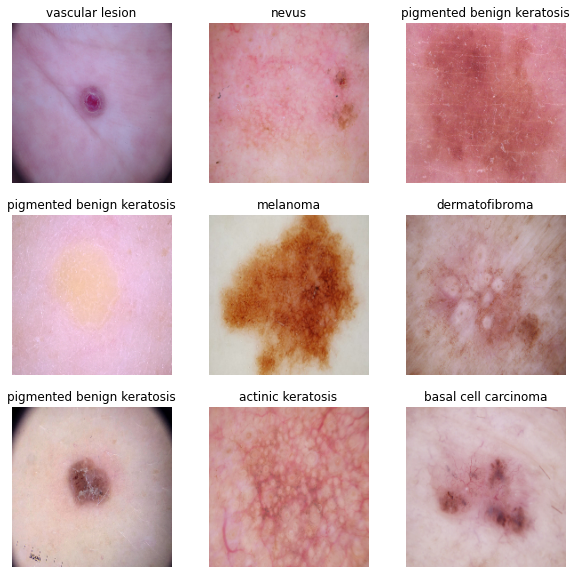

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
train_ds = train_ds.map(lambda x, y: (tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)(x), y))
val_ds = val_ds.map(lambda x, y: (tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)(x), y))

In [12]:
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [13]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.02926655 0.8346479


In [14]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
def add_dropout_layer(model):
  model.add(Dropout(0.2))

In [16]:
def add_conv_and_pool_layers(model, feature_map=32, filter_size = 3, activation_fn="relu",first_layer = False, add_dropout = False):
  if first_layer:
    model.add(Conv2D(feature_map, (filter_size, filter_size), activation=activation_fn, padding='same', input_shape=(img_height, img_width, 3)))
    model.add(MaxPool2D())
  else:
    model.add(Conv2D(feature_map, (filter_size, filter_size), activation=activation_fn, padding='same'))
    model.add(MaxPool2D())
  if add_dropout:
    add_dropout_layer(model)

In [17]:
num_classes = len(class_names)
def get_model(data_augmentation = False, add_dropouts = False):
  model = Sequential()
  if data_augmentation:
    model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
    model.add(layers.experimental.preprocessing.RandomRotation(0.2))
  
  add_conv_and_pool_layers(model, 32, 3, "relu", True, add_dropout=add_dropouts)
  add_conv_and_pool_layers(model, 64, 3, "relu", False, add_dropout=add_dropouts)
  add_conv_and_pool_layers(model, 64, 3, "relu", False, add_dropout=add_dropouts)
  add_conv_and_pool_layers(model, 128, 3, "relu", False, add_dropout=add_dropouts)
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(num_classes, activation='softmax'))
  return model

In [18]:
### Todo, choose an appropirate optimiser and loss function
model = get_model()


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)      

### Train the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 38s 680ms/step - loss: 1.9802 - accuracy: 0.2628 - val_loss: 1.9059 - val_accuracy: 0.3647
Epoch 2/20
56/56 [==============================] - 50s 898ms/step - loss: 1.7361 - accuracy: 0.3677 - val_loss: 1.6431 - val_accuracy: 0.4094
Epoch 3/20
56/56 [==============================] - 52s 927ms/step - loss: 1.5747 - accuracy: 0.4269 - val_loss: 1.6399 - val_accuracy: 0.4228
Epoch 4/20
56/56 [==============================] - 50s 890ms/step - loss: 1.4783 - accuracy: 0.4732 - val_loss: 1.5177 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 49s 875ms/step - loss: 1.4415 - accuracy: 0.4849 - val_loss: 1.7472 - val_accuracy: 0.3826
Epoch 6/20
56/56 [==============================] - 47s 833ms/step - loss: 1.3838 - accuracy: 0.5073 - val_loss: 1.3884 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 51s 910ms/step - loss: 1.3484 - accuracy: 0.5229 - val_loss: 1.5572 - val_accuracy: 0.4474

### Visualizing training results

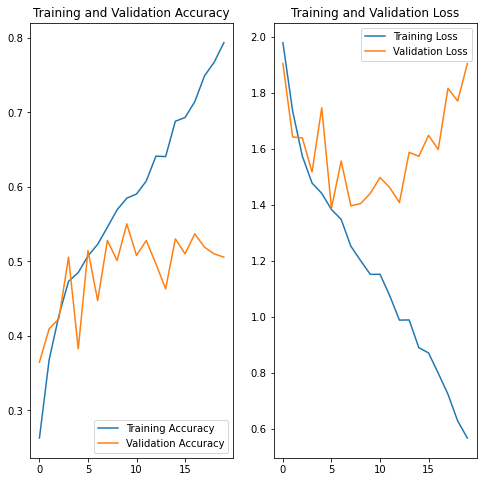

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

#### Training accuracy is increasing with every epoch but validation accuracy is always around 50% which is clear sign of __Overfitting__

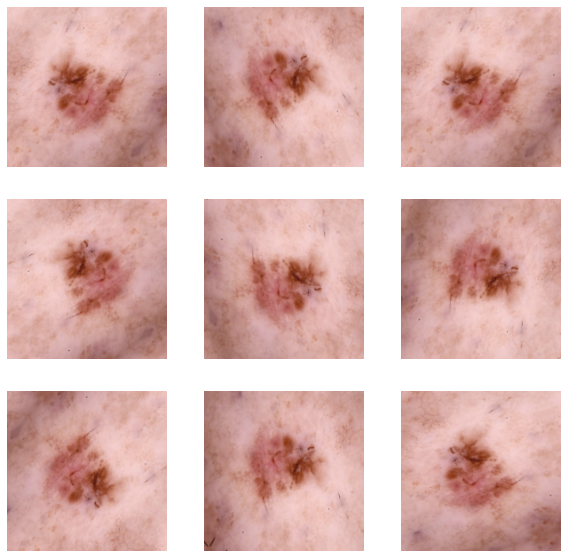

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(images)
    plt.imshow(augmented_image[0])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model_2 = get_model(data_augmentation=True, add_dropouts=True)


### Compiling the model

In [25]:
## Your code goes here
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 73s 1s/step - loss: 2.0710 - accuracy: 0.2042 - val_loss: 2.0085 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 73s 1s/step - loss: 1.8578 - accuracy: 0.3209 - val_loss: 1.8234 - val_accuracy: 0.3244
Epoch 3/20
56/56 [==============================] - 69s 1s/step - loss: 1.6628 - accuracy: 0.3901 - val_loss: 1.6176 - val_accuracy: 0.4228
Epoch 4/20
56/56 [==============================] - 75s 1s/step - loss: 1.6304 - accuracy: 0.4185 - val_loss: 1.6098 - val_accuracy: 0.4586
Epoch 5/20
56/56 [==============================] - 72s 1s/step - loss: 1.5418 - accuracy: 0.4498 - val_loss: 1.5385 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 72s 1s/step - loss: 1.4722 - accuracy: 0.4838 - val_loss: 1.4845 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 70s 1s/step - loss: 1.4521 - accuracy: 0.4911 - val_loss: 1.4781 - val_accuracy: 0.5213
Epoch 8/20
56/56 [==

### Visualizing the results

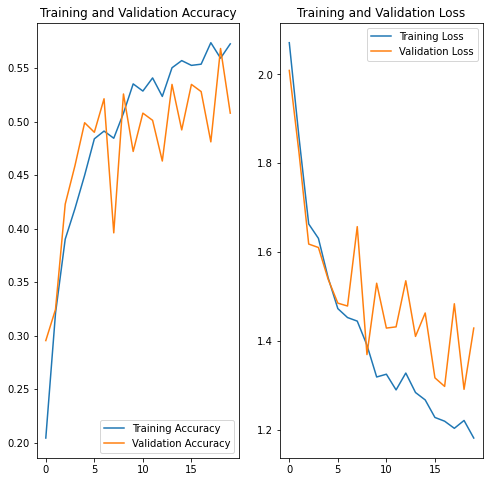

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Accuracy on train and validation dataset is almost same which means that model is not overfitting the training data but the accuracy is still around 50% which means it is not able to identify all(or most) variance of the data which means it is underfitting the dataset.


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.
## Your code goes here.
from collections import Counter
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: count for cls, count in counter.items()}


In [29]:
y = np.concatenate([y for x, y in train_ds], axis=0)
class_dist = get_class_weights(y)
final_dict = {}
for k, v in class_dist.items(): 
  final_dict[class_names[k]] = v

print(final_dict)

{'pigmented benign keratosis': 370, 'basal cell carcinoma': 309, 'vascular lesion': 115, 'nevus': 277, 'melanoma': 352, 'seborrheic keratosis': 58, 'dermatofibroma': 77, 'actinic keratosis': 92, 'squamous cell carcinoma': 142}


<BarContainer object of 9 artists>

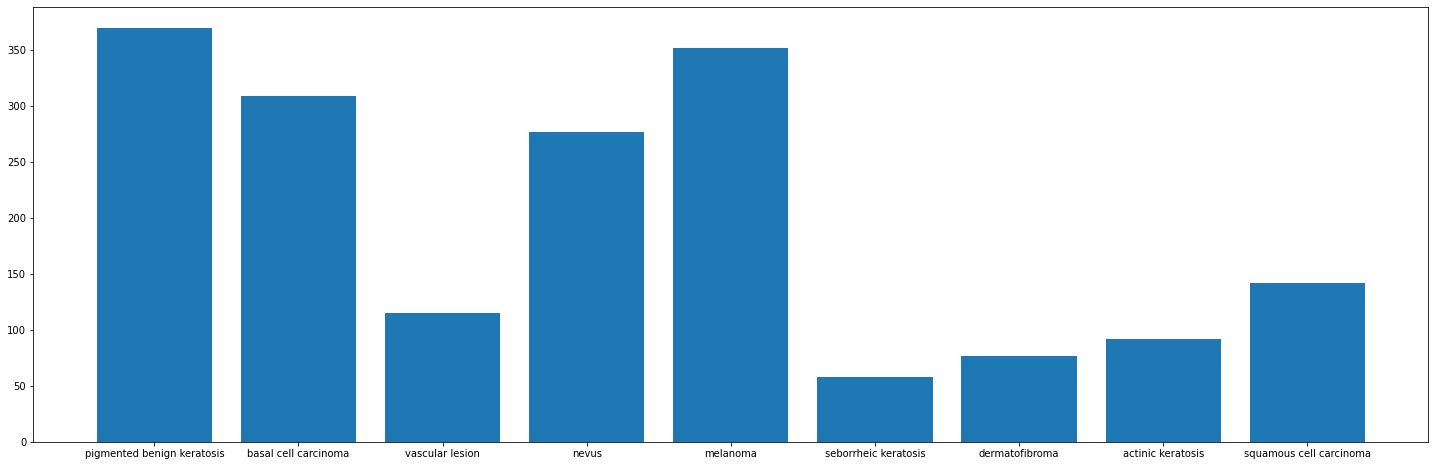

In [30]:
plt.figure(figsize=(25, 8))
plt.bar(final_dict.keys(), final_dict.values())

#### **Todo:** Write your findings here: 
 - Which class has the least number of samples?
     - __seborrheic keratosis__
 - Which classes dominate the data in terms proportionate number of samples?
   - __pigmented benign keratosis__


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(f"{data_dir_train}/{i}")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FFC10C5CEB0>:   0%|          | 1/500 [00:00<00:57,  8.73 Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FFC109DEE50>: 100%|██████████| 500/500 [00:09<00:00, 54.37 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FFC10BB4640>: 100%|██████████| 500/500 [00:08<00:00, 59.65 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFC10BC2CA0>: 100%|██████████| 500/500 [00:07<00:00, 66.48 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FFC10181A90>:   1%|          | 3/500 [00:00<00:41, 11.97 Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FFC1096F1C0>: 100%|██████████| 500/500 [00:43<00:00, 11.52 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FFC10983AF0>: 100%|██████████| 500/500 [00:43<00:00, 11.42 Samples/s]  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFCF06072B0>: 100%|██████████| 500/500 [00:06<00:00, 72.29 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FFC0F5BAD60>: 100%|██████████| 500/500 [00:17<00:00, 29.30 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FFC1096AB50>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFCF060AFA0>: 100%|██████████| 500/500 [00:06<00:00, 79.24 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FFC11375490>: 100%|██████████| 500/500 [00:07<00:00, 68.39 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
from glob import glob

In [35]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010690.jpg_ad504b86-6184-41f0-ac32-bbe00e7568b6.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009955.jpg_64d1b341-f5c9-44bb-badc-33702e279330.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000295.jpg_aecfa22a-1729-41bf-82a0-0db07413bf87.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000463.jpg_f00d5885-0705-48ec-86bb-23a42a0b5911.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010468.jpg_42580d61-4aae-4bc2-be02-4055c8d55459.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010766.jpg_2ab81720-90ea-410d-a9cc-73f1a81ec38f.jpg',
 'Skin cancer IS

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [37]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [38]:
# df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [39]:
# new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
# data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train = pathlib.Path(os.path.join("Skin cancer ISIC The International Skin Imaging Collaboration", "Train"))
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
### Your code goes here
train_ds = train_ds.map(lambda x, y: (tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)(x), y))
val_ds = val_ds.map(lambda x, y: (tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)(x), y))

In [44]:
## your code goes here
model_3 = get_model(data_augmentation=False, add_dropouts=True)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## your code goes here
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [46]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 237s 1s/step - loss: 2.1916 - accuracy: 0.1374 - val_loss: 2.1340 - val_accuracy: 0.1930
Epoch 2/30
169/169 [==============================] - 246s 1s/step - loss: 1.9368 - accuracy: 0.2608 - val_loss: 1.7069 - val_accuracy: 0.3823
Epoch 3/30
169/169 [==============================] - 229s 1s/step - loss: 1.6261 - accuracy: 0.3744 - val_loss: 1.5090 - val_accuracy: 0.4395
Epoch 4/30
169/169 [==============================] - 204s 1s/step - loss: 1.4229 - accuracy: 0.4514 - val_loss: 1.3634 - val_accuracy: 0.5033
Epoch 5/30
169/169 [==============================] - 197s 1s/step - loss: 1.3361 - accuracy: 0.4861 - val_loss: 1.3376 - val_accuracy: 0.4907
Epoch 6/30
169/169 [==============================] - 186s 1s/step - loss: 1.2214 - accuracy: 0.5358 - val_loss: 1.2352 - val_accuracy: 0.5486
Epoch 7/30
169/169 [==============================] - 173s 1s/step - loss: 1.0633 - accuracy: 0.6059 - val_loss: 1.0437 - val_accuracy: 0.6192

#### **Todo:**  Visualize the model results

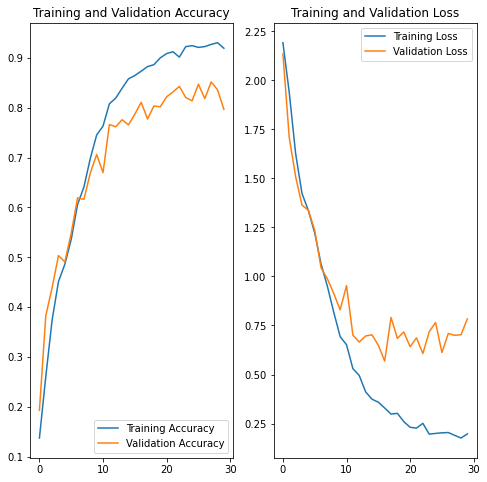

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


__Training Accuracy: 90%__
__Validation Accuracy: 85%__

Validation accuracy increased from 50% in first model to 85% in the last model.<br>
Yes, Difference between Training to validation accuracy is ~5%. 

